# Explore the data set

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import re
import seaborn as sns

In [2]:
df= pd.read_csv('ratings_Electronics.csv',sep=',',names=['userid','productid','ratings','timings'])


In [3]:
df.head()


,userid,productid,ratings,timings
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
df.shape

(7824482, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
userid       object
productid    object
ratings      float64
timings      int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [4]:
df.drop(['timings'],axis=1,inplace=True)

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ratings,7824482.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


In [37]:
df.isna().sum()

userid       0
productid    0
ratings      0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B840E99908>]],
      dtype=object)

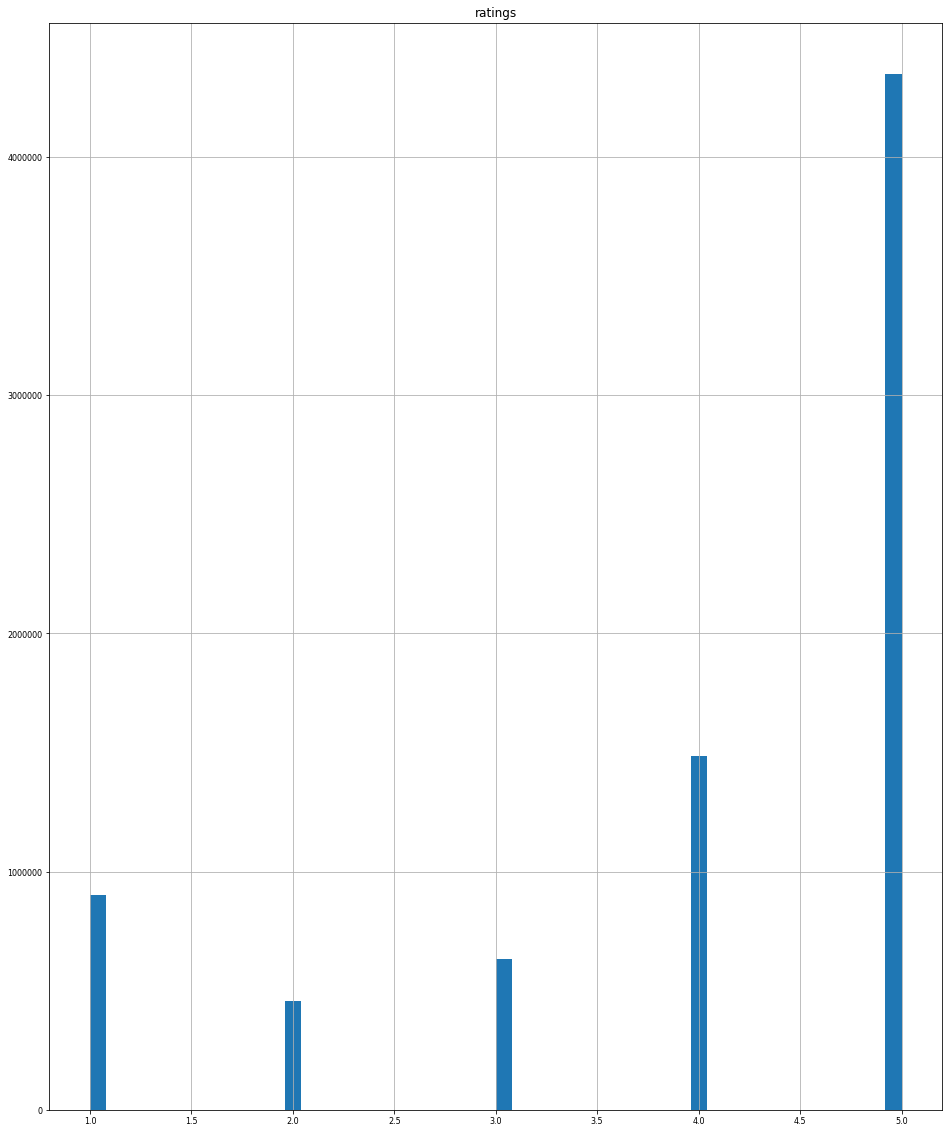

In [7]:
df.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

# Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 50 or more number of ratings )

In [38]:
df_cnt=df.userid.value_counts()
df_rating = df[df.userid.isin(df_cnt[df_cnt >=150].index)]

## To avoid Memory error, filter the user data who has given rating >150 times

In [39]:
df_rating.shape

(21960, 3)

In [11]:
#df_rating =df_rating.pivot(columns=['userid','productid'], values='ratings').fillna(0)


# Popularity based model

In [37]:
print('Weighted Rating (WR) = (vv+m.R)+(mv+m.C)') 

##v is the number of votes for the product;
##m is the minimum votes required to be listed in the chart;
##R is the average rating of the product; And
##C is the mean vote across the whole report

print('Calculating the Popularity of the product based on Weighted Rating formula')

Weighted Rating (WR) = (vv+m.R)+(mv+m.C)
Calculating the Popularity of the product based on Weighted Rating formula


In [52]:
df_mean=df_rating.groupby('productid')['ratings'].mean()

In [53]:
df_count=df_rating.groupby('productid')['ratings'].count()

In [54]:

df_score=pd.merge(df_mean, df_count, on='productid')

In [55]:
c=df_score['ratings_x'].mean()
m=df_score['ratings_y'].quantile(0.90)

In [56]:
df_score.head()

,ratings_x,ratings_y
productid,,
0970407998,4.0,1
0972683275,5.0,1
1400532655,1.0,1
1400699169,5.0,1
8862936826,2.0,1


In [57]:
def weighted_rating(x, m=m, C=c):
    v = x['ratings_y']
    R = x['ratings_x']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [58]:
df_score['score'] = df_score.apply(weighted_rating, axis=1)

In [60]:
#df_score.rename(index = {"ratings_x": "ratings_avg",                     "ratings_y":"ratings_cnt"},                                  inplace = True) 

print('ratings_x denotes Mean & ratings_y denotes count')

ratings_x denotes Mean & ratings_y denotes count


In [59]:
print('Top 5 Popular Products based on voting by customers')
df_score.sort_values('score',ascending=False).head()

Top 5 Popular Products based on voting by customers


,ratings_x,ratings_y,score
productid,,,
B003ES5ZUU,5.000000,31,4.936651
B00G4UQ6U8,4.952381,21,4.868588
B002WE6D44,5.000000,13,4.865382
B00ISFNSBW,5.000000,11,4.846151
B001TH7GUU,5.000000,10,4.834317


# Collaborative Filtering model

In [61]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import KNNWithMeans
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

In [9]:
df_rating.shape

(125871, 3)

In [62]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_rating[['userid','productid','ratings']],reader)

# hyperparameter tuning to find best model

In [19]:
from surprise.model_selection import GridSearchCV

sim_options = {
    "name": ["msd", "cosine"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
}

param_grid = {"sim_options": sim_options}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=3)
gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

# split train & test

In [63]:
trainset, testset = train_test_split(data, test_size=.30)

In [64]:
sim_options = {
    "name": "cosine",
    "min_support":5,
    "user_based": True,  # Compute  similarities between items
}
algo = KNNWithMeans(sim_options=sim_options)
algo.fit(trainset)


Computing the cosine similarity matrix...
Done computing similarity matrix.


In [65]:
pred=algo.test(testset)

In [66]:
print("Accuracy",accuracy.rmse(pred))

RMSE: 0.9827
Accuracy 0.9826847144085995


In [41]:
##prediction=algo.predict('A17BUUBOU0598B',5)


In [40]:
df_rating.productid.unique()

array(['0970407998', '0972683275', '1400532655', ..., 'B00LGQ6HL8',
       'B00LI4ZZO8', 'B00LKG1MC8'], dtype=object)

In [45]:
prediction.est

4.316809784022899

In [46]:
pred

[Prediction(uid='A17BUUBOU0598B', iid='B000XZJCMO', r_ui=4.0, est=4.316809784022899, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A15QYHQH80W30L', iid='B009924TSY', r_ui=5.0, est=4.363636363636363, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A12DQZKRKTNF5E', iid='B005I6DVC0', r_ui=3.0, est=4.316809784022899, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3A4ZAIBQWKOZS', iid='B000068O16', r_ui=5.0, est=4.624277456647399, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A5JLAU2ARJ0BO', iid='B0000DBJTZ', r_ui=2.0, est=3.948369565217391, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2NYK9KWFMJV4Y', iid='B00EPD45GI', r_ui=5.0, est=4.316809784022899, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A22CW0ZHY3NJH8', iid='B005GM1Q1O', r_ui=4.0, est=2.607974221238991, details={'actual_k': 3, '

In [27]:
#user_prod_rating['0594481813']

# Top 5 recommendatiions to the users based on collabarative filtering model prediction

In [30]:
from collections import defaultdict
 
def get_top5_recommendations(predictions, topN = 5):
     
    top_recs = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_recs[uid].append((iid, est))
     
    for uid, user_ratings in top_recs.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_recs[uid] = user_ratings[:topN]
     
    return top_recs

In [33]:
top5_recommendations = get_top5_recommendations(pred)

In [34]:
top5_recommendations

defaultdict(list,
            {'A2PSC7LUNIDEAH': [('B000HCT12O', 5),
              ('B0079R8KO0', 4.838742193647255),
              ('B000MQ695W', 4.6521739130434785),
              ('B0044TXDSE', 4.6521739130434785),
              ('B00AQUO5RI', 4.6521739130434785)],
             'AT6CZDCP4TRGA': [('B0006VX1G8', 4.25932651601993),
              ('B006RA0ODK', 4.25932651601993),
              ('B0028N7852', 4.25932651601993),
              ('B000R6QAC4', 4.25932651601993),
              ('B00008X5DC', 4.25932651601993)],
             'A3BNMHRW2R35LK': [('B001TH7GSW', 5),
              ('B00C5DN9E4', 5),
              ('B00275XTSQ', 5),
              ('B00884WH74', 5),
              ('B001418WF4', 4.25932651601993)],
             'A1YEPFLLH42OU1': [('B001XURP7W', 5),
              ('B007PTCFFW', 5),
              ('B0052SCU8U', 5),
              ('B006TT91TW', 4.9766637856525495),
              ('B00884WH74', 4.824029018844555)],
             'A20DDH4NT6Q1E8': [('B000GK8LVE', 5),
      

# Insights

In [72]:
print('1.Data set has only 3 columns - userid,productid & ratings. Seems this is not a complex dataset so no need to apply SVD or Matrix Factorization.')

print('2.There\'s no NaN or Null values present in the dataset')

print('3.Most of the user has given 5 ratings  based on Histogram graph')

print('4.Applied weighted ratings and found Popular products')

print('5.Using GridSearchCV - Identified the best hyper parameters')

print('6. Got RMSE score 0.98 - denotes that actual & prediction are more or less the same with out any deviation')

print('7.From the Collaborative Filter model prediction - Identified Top 5 products that can recommend for each user')



1.Data set has only 3 columns - userid,productid & ratings. Seems this is not a complex dataset so no need to apply SVD or Matrix Factorization.
2.There's no NaN or Null values present in the dataset
3.Most of the user has given 5 ratings  based on Histogram graph
4.Applied weighted ratings and found Popular products
5.Using GridSearchCV - Identified the best hyper parameters
6. Got RMSE score 0.98 - denotes that actual & prediction are more or less the same with out any deviation
7.From the Collaborative Filter model prediction - Identified Top 5 products that can recommend for each user
